# Introduction!
We are working with **a very obalance dataset**, and the task is to detect clients who **churn**. We have to choose a model that can predict  accurately those churns client to understand why they left the company, and to achieve that task i used the following models:<br>

1) Logistic regression
2) GradientBoostingClassifier
3) RandomForest

### **For the first 2 models** i applied the same methodology:
After splitting the data into train e test, i trained the models and check the metrics. then i applied **a threshold** and check if the metrics got better. <br>Then, i used **SMOTE oversampling tecnique**, trained again those 2 model with the resempled data, and check the parameters  to see if the metrics could get even better. Finally i added a threshold even i the resempled data and check for the last time if the matrics got better.

For **RandomForest** model instead, i didnt use thresholds or Smote, but i relied on an **inbuild parameter** called **class_weight='balanced'** that add **"more weigth"** to the minority class, so the model wont **"ignore it"**  

I also encoded the data with labelEncoder and OneHotEncoder, and did some **feature selection**, deleting some features that wasn't relevant for the models.


## What is important to think in this case?

The goal is to get more **TP** as we can, at the lowest **FP** price. **TP** are the class 1 churn clients, and represent the clients that left the company. (A little reminder: When **TP** increase, **FN** decrease accordly.)  

# A litle knowledge about the matrics that we going to check to ensure that the model is good for our purpuse:

🔹 **precision_score**: It measures in **%** how many of the predicted positive cases are actually correct compared to y_test(our real churn label 1). It answers: "When the model predicts positive, how often is it right?" High precision means lower false positives. 

🔹 **Recall_Score**:
Recall evaluates how well the model captures all actual positive cases. It answers: "Of all real positives, how many did the model find?" High recall means low false negatives.

🔹 **F1 Score**
The F1 Score is the **harmonic mean of precision_score and recall_score**. It balances both metrics, especially useful in imbalanced datasets where high precision or recall alone may be misleading.

# At the end of this page i ll show wich model i think is better for this task and why

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
## Importing the dataset
# The data in our Excel dataset is separated by ";", so to prevent pandas from reading the data incorrectly, we use the sep=";" and decimal="" flags.

# df = pd.read_csv("elevera_data_set.csv",sep=";" ,decimal=",") 
df =  'dummy pd.read_csv("elevera_data_set.csv",sep=";" ,decimal=",")' # use the df above, this is just to not have an error on pushing this code on github

In [10]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
3,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
4,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No


In [11]:
df.shape # nr of rows and columns

(5374, 21)

### Delete the "arbitrary" data column "customerID", because it is an "identifier" and therefore the model dont need that (it can lead it to run into problems of poor generalization and overfitting)


In [12]:

df.drop(columns=["customerID"], inplace=True)

In [13]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
3,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
4,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No


### Let's see if any columns have missing data, and if so let's fill them with the average of the data in that column (for numeric features only)

In [14]:
df.isnull().sum() # TotalCharges har 11 missinValues(nullValue). Nu vi ersätter de values med the median of column values

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [15]:
df["TotalCharges"].fillna(df["TotalCharges"].mean(),inplace=True) #changed the  missingValues with the mean of the values of that column. 
# Ps There are other fillna techniques if we want to try in future to see if the model works better

C:\Users\ale\AppData\Local\Temp\ipykernel_22816\3767342820.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].mean(),inplace=True) #changed the  missingValues with the mean of the values of that column.


In [16]:
df.isnull().sum() # Data added correctly

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [17]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
3,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
4,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No


###  As we know, models must be feed with numeric data to work, so the next step is to fund the categorical data in our columns, and trasform it with labelEncode, and onHoteEncoder.
While classification models like xgBoost and randomForest can handle a simple LabelEncoder, linear or logistic regression models can lead to misclassification with columns with more than 3 different categories. So we transform columns with binary categories with a simple labesEncoded, and columns with more than 3 categories with OneHotEncoder.<br>
**! important**. If some columns have tens or hundreds of categories, the number of new columns **will be very high**, and **you may run into memory or sparse data issues**.
In the case of this dataset, however, this is not a problem because we only have 10 columns that contains a maximum of 4 different categories, so we can use this technique without any problems




<!-- 
Anche se modelli di classificazioni come xgBoost e randomForest se la cavano bene anche con un semplice LabelEncoder, modelli lineari o di regressione logistica possono portare ad errori di classificazione con colonne con piu' di 3 categorie diverse. quindi trasformiamo le colonne con categorie binari con semplice labesEncoded, e le colonne con piu' di 3 categorie con OneHotEncoder.<br>
**! importante**. Se alcune colonne hanno decine o centinaia di categorie, il numero di nuove colonne **sarà molto alto**, e **potresti incorrere in problemi di memoria o sparse data**.
Nel caso di questo db pero' non e' un problema perche' abbiamo solo 10 colonne che hanno al massimo 4 categorie diverse, quindi possiamo usare senza problemi questa tecnica -->

In [18]:
# Import encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
Ohe = OneHotEncoder(drop='first', sparse_output=False) # drop='first' to avoid ridondant data, sparse_output='false' return a 2d array(good for Pandas)
# Apply labelEncode and oneHotEncode accordly: (Uncomment the prints see the categories number)
for col in df.select_dtypes(include=['object', 'category']).columns: # find categorical data
    num_unique = df[col].nunique()
    if num_unique > 2:
        # Update the df columns with the encoded data
         encoded = Ohe.fit_transform(df[[col]]) #  fit_Transform Only on train data,  just transform on test data. [[col]] => duble squarebracket to mantain the 2d array form
         encoded_df = pd.DataFrame(encoded, columns=Ohe.get_feature_names_out([col])) # create a new dataset that contains the column with more than 2 cat data, and the new column name are same as the categorical data name
         df = df.drop(columns=[col]) # drop the column with more than 2 categ data
         df = pd.concat([df, encoded_df], axis=1) # add to our mother df the new oneHot encoded data
         print(f"Column '{col}' has {num_unique} categories") #Uncomment to see Column name with more than 2 categorical data
       
    else:
        print(f"Column '{col}' has {num_unique} categories")  #Uncomment to see Column name with  2 categorical data
        df[col] = le.fit_transform(df[col])  # Only fit_Transform on train data, end just transform on test data
        # Update the df columns with the encoded data

## this loop check if the column has more or less than 2 categorical data, and use the encoder accordly 

Column 'gender' has 2 categories
Column 'Partner' has 2 categories
Column 'Dependents' has 2 categories
Column 'PhoneService' has 2 categories
Column 'MultipleLines' has 3 categories
Column 'InternetService' has 3 categories
Column 'OnlineSecurity' has 3 categories
Column 'OnlineBackup' has 3 categories
Column 'DeviceProtection' has 3 categories
Column 'TechSupport' has 3 categories
Column 'StreamingTV' has 3 categories
Column 'StreamingMovies' has 3 categories
Column 'Contract' has 3 categories
Column 'PaperlessBilling' has 2 categories
Column 'PaymentMethod' has 4 categories
Column 'Churn' has 2 categories


In [19]:
df.shape

(5374, 31)

In [20]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,0,0,0,45,0,0,42.30,1840.75,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0,0,1,22,1,1,89.10,1949.40,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,0,0,10,0,0,29.75,301.90,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
df['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
5369    0
5370    0
5371    0
5372    0
5373    0
Name: SeniorCitizen, Length: 5374, dtype: int64

# Feature selection

In [22]:
df['SeniorCitizen'].value_counts() # check if value count has to be dropped. (it has not to be)

SeniorCitizen
0    4658
1     716
Name: count, dtype: int64

In [23]:
# Check ridondant data to drop (not found)
constant_columns = [col for col in df.columns if df[col].nunique() <= 1 ]

print("Colonne con un solo valore:")
print(constant_columns)

Colonne con un solo valore:
[]


### Down we check the correlations(positive or negative) between the columns in the dataset. The hight positive or negative related columns had to be dropp because they are not good for the model. The rows of each feature is translated as a **vector in the space**, that has n-rows dimentions. if in two or more column, all rows of the dataset has almost same values, its is like we have 2 vector that have the same direction in the space, and it confuse the model. And it the same if the correlation is negative, meaning that the vectore of one feature is the equivalent negative vector of anothe feature vector


### PS, if oneHotEncoded data has been done with the drop="first" flag like in this exemple, and labelEncoded has been used to trasform only those column with binary class, they will not have a correlation higher than 50%, so this encoded data will not be showed in the code below

In [24]:
threshold = 0.8
corr_matrix = df.corr(numeric_only=True)

# Maschera diagonale e valori sotto soglia
high_corr = corr_matrix[(abs(corr_matrix) > threshold) & (abs(corr_matrix) < 1.0)]
print(high_corr.dropna(how='all').dropna(axis=1, how='all'))

# As we see, the correlation between PhoneService and "MultipleLines_No phone service" has a perfect negative corr, meaning that MultipleLines_No phone service
# has to be dropped(we dropp it because it is the more logical column to drop,and because is of course the less important feature betwen the 3. keep reading to understand more). 
# In fact, if we check the initial dataset before the encoding, we can notice that in the first 5 rows of df.head(), on every row
# under PhoneService feature that has the values = "NO",  the value of MultipleLines feature is always equal to "No phone service". 
# So even if we drop that column "MultipleLines_No phone service", (that remember has been dropped by default with oneHotEncoding(drop="first")), it wont be a problem
# because PhoneService and MultipleLines_Yes alone will still represent the column values 'MultipleLines_No'. Thats because when 'PhoneService' value
# is = 0(NO) and 'MultipleLines_Yes' values is = 0(NO), thats is equal to "No phone service ('MultipleLines_No')" value, so there is no need to keep MultipleLines_No, 
# because the model understand it by 'PhoneService' and 'MultipleLines_Yes' data. This way the dataset ll have less unecessary columns while still mantains all
# important data. 

                                PhoneService  MultipleLines_No phone service
PhoneService                             NaN                            -1.0
MultipleLines_No phone service          -1.0                             NaN


As we see in the output above, the correlation between PhoneService and "MultipleLines_No phone service" has a perfect negative corr, meaning that MultipleLines_No phone service has to be dropped(we dropp it because it is the more logical column to drop,and because is of course the less important feature betwen the 3. keep reading to understand more). <br>
In fact, if we check the initial dataset before the encoding, we can notice that in the first 5 rows of df.head(), on every row
under PhoneService feature that has the values = "NO",  the value of MultipleLines feature is always equal to "No phone service". 
So even if we drop that column "MultipleLines_No phone service", (that remember has been dropped by default with oneHotEncoding(drop="first")), it wont be a problem
because PhoneService and MultipleLines_Yes alone will still represent the column values 'MultipleLines_No'. Thats because when 'PhoneService' value is = 0(NO) and 'MultipleLines_Yes' values is = 0(NO), thats is equal to "No phone service ('MultipleLines_No')" value, so there is no need to keep MultipleLines_No, because the model understand it by 'PhoneService' and 'MultipleLines_Yes' data. This way the dataset ll have less unecessary columns while still mantains all important data

In [ ]:
# Lets drop MultipleLines_No phone service  
df = df.drop(columns=["MultipleLines_No phone service"])

### Usualy, features that contain >90/95% of constant values has to be dropped because that data is not relevant for the model. But in a obalanced Dataset like this one, if those columns are releted with the target feature **(Churn)**, better not to drop it/those, because it means that those features contains important and relevant data for the prediction of churn. <br> Down i check all the features that has obalanced values, and then i confront those columns with the target value to see if there is important relation betwen them. if so, i dont delete the feature, otherwise can we delete them


In [28]:
# Lets found all the obalanced features (least > 90% obalancing)
for col in df.columns:
    top_freq = df[col].value_counts(normalize=True).values[0] # values[0] is equal to the most dominant value in the features  
    if top_freq > 0.9:
        print(f"{col}:{top_freq:.2%} same values") # .2% = the decimal nr to show (could be 3,4...)


# here we got the features name that are very obalanced: Churn of course, and PhoneService
# PS be sure that the columns have no missing values to perform this operation (already done with df.isnull().sum())


PhoneService:90.16% same values
Churn:96.28% same values


In [29]:
# analize those 2 columns
df["PhoneService"].value_counts(normalize=True) 
# 1(yes)  =  0.901563 => (.values[0], the dominant value)
# 0(no)  =  0.098437
# 90.1% has phone
# 9.8% has not the phone

PhoneService
1    0.901563
0    0.098437
Name: proportion, dtype: float64

In [30]:
df["Churn"].value_counts(normalize=True)
# 0(no)  =  0.962784 => (.values[0], the dominant value)
# 1(yes) =   0.037216
# 96% clients stayed with the company
# 4% left the company

Churn
0    0.962784
1    0.037216
Name: proportion, dtype: float64

In [31]:
# pd.crosstab shows a table that confront all values of Feature column with the value of Churn column.
# Thats means that in all rows where PhoneService values is 0(No), 0.967864(96%) of values in Churn has 0(No) too, and 0.032136(3%) values 1(yes)
# with the same logic, in all rows where PhoneService values is 1(yes), 0..962229(96%) of values in Churn has 0(No) and 0.037(3%) has value 1(yes)
pd.crosstab(df['PhoneService'], df['Churn'], normalize='index')
# its kinda do a median where the class are the same row for row, and return the procent of the maching values for that value (0 and 1)

Churn,0,1
PhoneService,,
0,0.967864,0.032136
1,0.962229,0.037771


### This tabel is very usefull to understand if a feature is associated to target Churn and wich category has more probability of "Churn".<br><br>

### What does this table mean?<br> Even though most customers have PhoneService = 1, the probability of churn is slightly higher in that group (3.8% vs. 3.2%).<br><br>This small difference may contain information that helps the model distinguish churners from non-churners. in simple word that means that the Clas 1(Yes) in PhoneService, is relevant for the churn class 1(yes) and thats why we dont wanna delete it for now

# Now lets split the dataset with trai_test_split

In [32]:
# lets move the churn column at the last column position, because right now it is at position 9:
cols = list(df.columns)
col_to_move = cols[9]
cols.append(cols.pop(9))
df = df[cols]

In [33]:
X = df.iloc[:,:-1].values # 2D array
y = df.iloc[:,-1].values # 1d array

## Data split 

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Before scaling the data, let's see how many outliers there are in our dataset. The code below divides the dataset into percentiles, calculates the outliers in each feature, and calculates the total average of the outliers of all the columns. <br> If this final average is higher than > 5%, then we should use **RobustScaler**, which scales the data by calculating the median and IQR(x) so that the outliers do not affect the scaling of the "good" data (centered around the mean), but are only reflected in the scale of the **outliers themselves**. This scaling method is recommended when there are many outliers in the dataset precisely because they do not affect the scaling of the coherent data, i.e. those that do not distance themselves from the mean ("no-outliers"). <br>

### If instead the code shows us that there are relatively few total outliers, then we could use the classic **StandardScaler**.<br>
PS if a column contains **extreme values** we can also transform this data with **log1p(x)/yao-Johnsson** methods

<!-- ###  Prima di scalare i dati, vediamo quandi outliers ci sono nel nostro dataset. Il codice in basso divide il dataset in percentile, calcola gli outliers in ognuna feature, e fa la media totale degli outliers di tutte le colonne. <br> Se questa la media finale e superiore > 5%, allora ci conviene usare **RobustScaler**, che scala i dati calcolando la mediana e IQR(x) in modo che gli outliers non influenzino la scalature dei dati "buoni"(incentrati intorno alla media), ma si riflettono solo sulla scala degli **outliers stessi**. Questo metodo di scalatura e' consigliato in presenza di tanti outliers nel dataset prorio perche' questi non influenzano la scalatura dei dati coerenti, cioe' quelli  che non si distanziano dalla media("no-outliers"). <br>

### Se invece il codice ci mostra che ci sono relativamente pochi outliers totali, allora potremmo usare il sclassico **StandardScaler**. -->

In [35]:
import numpy as np

def check_outliers_iqr(X):
    n_features = X.shape[1]
    outlier_percentages = []

    for i in range(n_features):
        col = X[:, i]
        Q1 = np.percentile(col, 25)
        Q3 = np.percentile(col, 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = np.sum((col < lower_bound) | (col > upper_bound))
        percent_outliers = (outliers / len(col)) * 100
        outlier_percentages.append(percent_outliers)
        print(f"Feature {i}: {percent_outliers:.2f}% of outlier")

    # Media % outlier su tutte le feature
    mean_outliers = np.mean(outlier_percentages)
    print(f"\nAverage outlier on all the feature: {mean_outliers:.2f}%")

    # Suggerimento semplice sullo scaler
    if mean_outliers > 5:
        print("Ther are pretty much outlier, consider using RobustScaler.")
    else:
        print("Ther are pretty low outlier, You can use StandardScaler.")

    return outlier_percentages

# Uso
outlier_perc = check_outliers_iqr(X_train)

# We can use StandardScaler


Feature 0: 0.00% of outlier
Feature 1: 13.75% of outlier
Feature 2: 0.00% of outlier
Feature 3: 0.00% of outlier
Feature 4: 0.00% of outlier
Feature 5: 9.89% of outlier
Feature 6: 0.00% of outlier
Feature 7: 0.00% of outlier
Feature 8: 0.00% of outlier
Feature 9: 0.00% of outlier
Feature 10: 0.00% of outlier
Feature 11: 0.00% of outlier
Feature 12: 0.00% of outlier
Feature 13: 0.00% of outlier
Feature 14: 0.00% of outlier
Feature 15: 0.00% of outlier
Feature 16: 0.00% of outlier
Feature 17: 0.00% of outlier
Feature 18: 0.00% of outlier
Feature 19: 0.00% of outlier
Feature 20: 0.00% of outlier
Feature 21: 0.00% of outlier
Feature 22: 0.00% of outlier
Feature 23: 0.00% of outlier
Feature 24: 24.89% of outlier
Feature 25: 0.00% of outlier
Feature 26: 24.70% of outlier
Feature 27: 0.00% of outlier
Feature 28: 23.98% of outlier

Average outlier on all the feature: 3.35%
Ther are pretty low outlier, You can use StandardScaler.


In [36]:
# Lets scale the data with StandardScaler:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train) # fit_transform only for train data
X_test = sc_X.transform(X_test)  # trasform for test data


In [37]:
X_train

array([[ 0.98087601, -0.39923065, -1.05673615, ..., -0.57278404,
        -0.60359654, -0.56167916],
       [ 0.98087601, -0.39923065,  0.94631002, ..., -0.57278404,
        -0.60359654, -0.56167916],
       [-1.01949684, -0.39923065, -1.05673615, ..., -0.57278404,
         1.6567358 , -0.56167916],
       ...,
       [ 0.98087601, -0.39923065,  0.94631002, ..., -0.57278404,
         1.6567358 , -0.56167916],
       [ 0.98087601,  2.50481769,  0.94631002, ..., -0.57278404,
         1.6567358 , -0.56167916],
       [-1.01949684, -0.39923065,  0.94631002, ...,  1.7458587 ,
        -0.60359654, -0.56167916]], shape=(4299, 29))

### Trainin a Logistic regression model 

In [38]:
from sklearn.linear_model import LogisticRegression
sigm_classifier = LogisticRegression(random_state=0)

sigm_classifier.fit(X_train,y_train) # train the model with train data

LogisticRegression(random_state=0)

In [39]:
y_pred = sigm_classifier.predict(X_test) # lets do the test with our scaled test data and check if the metrics are good

In [40]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1075,))

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

ac = accuracy_score(y_test, y_pred) ## con le metriche si misura sempre i dati reali di y_test e i dati delle predizioni di X_test
cm = confusion_matrix(y_test,y_pred)
ps = precision_score(y_test,y_pred)
rec = recall_score(y_test,y_pred)
f1_s = f1_score(y_test,y_pred)
auc= roc_auc_score(y_test,y_pred)
# password supabase sql db = JYpDBngOoUhg2sUW
# https://supabase.com/dashboard/project/myrqslnfopwsqibvevrn/auth/policies?search=17269&schema=public
print('accuracy_score = ', ac)
print('confusion_matrix:')
print(cm)
print(' ')
print('precision_score = ', ps)
print('recall_score = ', rec)
print('f1_score = ', f1_s)

accuracy_score =  0.9646511627906976
confusion_matrix:
[[1037    0]
 [  38    0]]
 
precision_score =  0.0
recall_score =  0.0
f1_score =  0.0


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Modellen visade sig inte vara bra att classificera classen 1 i charn feature. confusion_matrix visar att modellen classificerade allt som 0(no), och att det missade 38 TP values som är det mest viktiga data att predicera  <br> Det beteende är vanligt när man jobbar med obalanserad dataset. För att öka antal TP , vi ska testa att sänka modellen's decision threshold:

In [42]:
# create a function that on call will return auc value of each different models
from sklearn.metrics import roc_curve, auc

def calculate_models_auc(models_props):
    fpr,tpr,thresholds = roc_curve(y_test,models_props)
    roc_auc = auc(fpr,tpr)
    return roc_auc

# in y_test there are:
# 38 1(yes) values
# 1037 0(no) values


In [43]:
y_probs = sigm_classifier.predict_proba(X_test)[:,1] # get the result of probability only of churn 1
 #(y_pred >=threshold).astype(int)

In [44]:
y_probs

array([0.00168096, 0.00132529, 0.00976645, ..., 0.08876774, 0.06969002,
       0.0027673 ], shape=(1075,))

In [45]:
# lower threshold
threshold = 0.3
y_pred_custom = (y_probs >= threshold).astype(int)

In [46]:
y_pred_custom

array([0, 0, 0, ..., 0, 0, 0], shape=(1075,))

In [47]:
# Check the metrics 
print('confusion_matrix:\n', confusion_matrix(y_test, y_pred_custom))
print('classification_report:\n', classification_report(y_test, y_pred_custom))
print("Roc =", calculate_models_auc(y_probs))



confusion_matrix:
 [[1029    8]
 [  36    2]]
classification_report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1037
           1       0.20      0.05      0.08        38

    accuracy                           0.96      1075
   macro avg       0.58      0.52      0.53      1075
weighted avg       0.94      0.96      0.95      1075

Roc = 0.8298482464599299


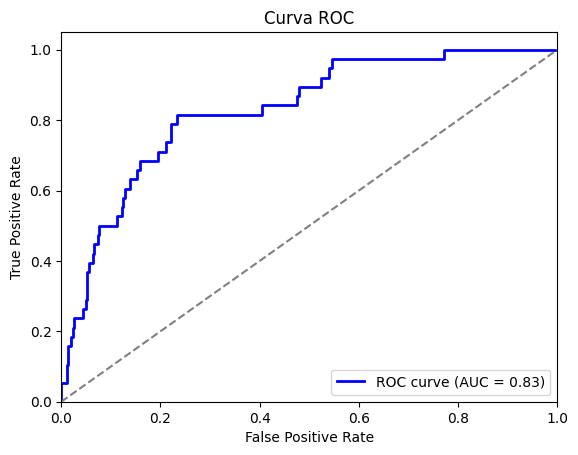

In [48]:
fpr,tpr,thresholds = roc_curve(y_test,y_probs)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Aggiungi la diagonale (linea casuale)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Aggiungi etichette e titolo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostra il grafico
plt.show()

### As we can see in the confusion matrics, even if we changed the decision threshold the model still not precise at all to classify the minority class. 
**!important fact**: the values ​​of **roc_curve and auc** seems good even though the model fails to separate the classes efficiently. this happens when we apply these metrics on **unbalanced datasets like this one**, because these metrics measure the overall ranking ability, but it does not take into account that the actual performance **on minority** classes can be poor. So it is not worth using them metrics in this context



# Lets Try with **SMOTE** tecnique to see if we can find a perfect balance, and achieve lower FP and **even more important lower FN**

### What is SMOTE? <br>

It is a oversempling tecnique that create sintetic data rows of the indipendent variables that has the minority class churn. It create similar data, **not copy** of the indipendent variables, and that why it is better than traditional **random oversampling**.<br>
Bacause use **K-NN** to create similar data, **its very important that data has been scaled with Standard or robustScaler**.
This metod will add extra data to the dataset

In [49]:
from imblearn.over_sampling import SMOTE # !pip install imbalanced-learn

In [50]:
smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5)
 # sampling_strategy='auto',  samples only the minority class
# k_neighbors=3 (generate syntetic data from the 5 nearest neighbors)

In [51]:
X_train.shape # total X_train data before smothe

(4299, 29)

In [52]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

In [53]:
X_train_resampled.shape # SMOTE  added 4000 more syntetic data that is similar to the data belonging to the minority churn class

(8274, 29)

In [54]:
y_train_resampled.shape

(8274,)

### Now SMOTE turned the dataset to a **balanced one**. Lets train the same model again with SMOTE DATA

In [55]:
# Check if smote added correctly the datas. churn classes should be 50-50 now
print(pd.Series(y_train_resampled).value_counts())
# Now the dataset is balanced

0    4137
1    4137
Name: count, dtype: int64


In [56]:
# Train model again:
SMOTE_sigm_classifier = LogisticRegression(random_state=0)
SMOTE_sigm_classifier.fit(X_train_resampled,y_train_resampled)

LogisticRegression(random_state=0)

In [57]:
# Predict data:

smote_y_pred = SMOTE_sigm_classifier.predict(X_test)

In [58]:
# Check metrics:
print("Confusion matrics =\n", confusion_matrix(y_test,smote_y_pred))
print(classification_report(y_test,smote_y_pred))
# print(precision_score(y_test,smote_y_pred))

Confusion matrics =
 [[805 232]
 [  9  29]]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      1037
           1       0.11      0.76      0.19        38

    accuracy                           0.78      1075
   macro avg       0.55      0.77      0.53      1075
weighted avg       0.96      0.78      0.85      1075



### With SMOOTE, the TP values raised, meaning that the model can recognize better the minority class 1. In fact, the FN are also lowered, and thats is also important because its meaning that the model dont classify as 0 the class that are actually 1. However, FP (0 real values that the model classified as 1) still hight.<br> 

# We dont need to consider the Precision Matrix, because in a obalanced dataset this matrix is missleading. 
## The recall matrics looks pretty accurate because the model predicted correctly 76% of the minority class 1 
# F1 score is a looks (continue later)

# Lets lower the threshol to see if we can get some more TP, possibly at a low FP cost
<!-- Now lets if lowering the threshold here can get even better  -->

In [59]:
# Lower the threshold

SMOTE_y_probs = SMOTE_sigm_classifier.predict_proba(X_test)[:,1] 
SMOTE_threshold = 0.3
SMOTE_y_pred_custom = (SMOTE_y_probs >= SMOTE_threshold).astype(int)

In [60]:
print("Confusion matrics =\n", confusion_matrix(y_test,SMOTE_y_pred_custom))
print('classification_report:\n', classification_report(y_test, SMOTE_y_pred_custom))

Confusion matrics =
 [[648 389]
 [  7  31]]
classification_report:
               precision    recall  f1-score   support

           0       0.99      0.62      0.77      1037
           1       0.07      0.82      0.14        38

    accuracy                           0.63      1075
   macro avg       0.53      0.72      0.45      1075
weighted avg       0.96      0.63      0.74      1075



### We can consider to lower even more the threshold if we really need a few more TP, but we gotta be aware that it will **cost many FP**

# Now lets see if we can do better  with the powerful **GradientBoostingClassificator**, which is one of the most powerful and **recommended** classifiers specially when dealing with unbalanced datasets


In [61]:
# import the classifier:
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
gbm = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1, max_depth=3,random_state=0)
# n_estimators=100 = number of trees 
# learning_rate Check how much each tree contributes to the final prediction. (Between 0.1 is good. higher can lead to overfitting)

In [63]:
gbm.fit(X_train,y_train)

GradientBoostingClassifier(random_state=0)

In [64]:
# Lets do the predictions on X_test as usually:

gbm_y_pred = gbm.predict(X_test)


In [65]:
gbm_y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(1075,))

In [66]:
print(f'Confusion Matrix  \n',confusion_matrix(y_test, gbm_y_pred))
print('classification_report:\n', classification_report(y_test, gbm_y_pred))

# By default, GradientBoostingClassifier is sligtly better than the logistic regressor classifier 

Confusion Matrix  
 [[1034    3]
 [  37    1]]
classification_report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1037
           1       0.25      0.03      0.05        38

    accuracy                           0.96      1075
   macro avg       0.61      0.51      0.51      1075
weighted avg       0.94      0.96      0.95      1075



<!-- ### Train  GradientBoostingClassifier with SMOTE data -->
### lower the threshold

In [67]:
# gbm_threshold = 0.3
# Lower the threshold

gbm_y_probs = gbm.predict_proba(X_test)[:,1] # [:,1] shows the probability  that the model assign the class 1 based on the data of each row in X_test 
gbm_threshold = 0.2
gbm_y_pred_custom = (gbm_y_probs >= gbm_threshold).astype(int) # astype(int) make False True to 0 and 1, so it make a new gbm_y_probs like array with lowered thresold data

In [68]:
print(gbm.predict_proba(X_test)) #[0.98334267 0.01665733]] 0.98334267 = prob that model assign class 0 at this row. 
# 0.01665733 prob that model assign class 1 

[[0.98334267 0.01665733]
 [0.99801143 0.00198857]
 [0.98747493 0.01252507]
 ...
 [0.97264371 0.02735629]
 [0.96804362 0.03195638]
 [0.99681142 0.00318858]]


In [69]:
# check confusion matrics and other matrics:
# gbm_y_pred_custom
print(f'Confusion Matrix  \n',confusion_matrix(y_test, gbm_y_pred_custom))  # always y_test at the begin of the matrics, and then
print('classification_report:\n', classification_report(y_test, gbm_y_pred_custom))

Confusion Matrix  
 [[1010   27]
 [  31    7]]
classification_report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1037
           1       0.21      0.18      0.19        38

    accuracy                           0.95      1075
   macro avg       0.59      0.58      0.58      1075
weighted avg       0.94      0.95      0.94      1075



### By lowering the thresold to 0.2 gained some  TP, but at a cost of pretty more FP. <br><br>Lets create a function that will find the threshold that has the best f1_score: 
(ps. With the same logic of this function we can also find the threshold with the best recall, or other matrics we wish. we can also add constrain, to find the best recal with the condition that precision_score has to be = 80%)

In [70]:
best_threshold = 0.5
best_f1 = 0
metrics = []

thresholds = np.arange(0.0, 1.01, 0.01)

for t in thresholds:
    y_pred = (gbm_y_probs >= t).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics.append((t, precision, recall, f1))
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"✅ Best threshold for F1: {best_threshold:.2f}")

✅ Best threshold for F1: 0.18


In [71]:
# assign the best threshold:
gbm_threshold = 0.18
gbm_y_pred_custom = (gbm_y_probs >= gbm_threshold).astype(int)

In [72]:
print(f'Confusion Matrix  \n',confusion_matrix(y_test, gbm_y_pred_custom))  # always y_test at the begin of the matrics, and then
print('classification_report:\n', classification_report(y_test, gbm_y_pred_custom))


Confusion Matrix  
 [[1004   33]
 [  28   10]]
classification_report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1037
           1       0.23      0.26      0.25        38

    accuracy                           0.94      1075
   macro avg       0.60      0.62      0.61      1075
weighted avg       0.95      0.94      0.94      1075



### Now, lets train this classifier with SMOTE DATA and see what hapens:

In [73]:
SMOTE_gbm = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1, max_depth=3,random_state=0)

In [74]:
SMOTE_gbm.fit(X_train_resampled,y_train_resampled)

GradientBoostingClassifier(random_state=0)

In [75]:
smote_gbm_y_pred = SMOTE_gbm.predict(X_test) 

In [76]:
# check the metrics:
print(f'Confusion Matrix  \n',confusion_matrix(y_test, smote_gbm_y_pred)) 
print('classification_report:\n', classification_report(y_test, smote_gbm_y_pred))

# As we can see the TP incresed and the FN decreased in confront to the lowered threshold. however the FP also increased and the TN decreased a bit
# But it detect better the minority class. lets lower the thres on this:

Confusion Matrix  
 [[996  41]
 [ 27  11]]
classification_report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1037
           1       0.21      0.29      0.24        38

    accuracy                           0.94      1075
   macro avg       0.59      0.62      0.61      1075
weighted avg       0.95      0.94      0.94      1075



In [77]:
Smote_gbm_y_probs = SMOTE_gbm.predict_proba(X_test)[:,1] # [:,1] shows the probability  that the model assign the class 1 based on the data of each row in X_test 
smothe_gbm_threshold = 0.20
Smote_gbm_y_pred_custom = (Smote_gbm_y_probs >= smothe_gbm_threshold).astype(int)

In [78]:
# Check matrics conf matrict on GradientBostingClassifier trained with SMOTE data
print(f'Confusion Matrix  \n',confusion_matrix(y_test, Smote_gbm_y_pred_custom)) # always y_test in the matrics
print('classification_report:\n', classification_report(y_test, Smote_gbm_y_pred_custom))

# we dubbled the TP but tripled th FP, meaning that many TN has not classified correctly

Confusion Matrix  
 [[903 134]
 [ 16  22]]
classification_report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      1037
           1       0.14      0.58      0.23        38

    accuracy                           0.86      1075
   macro avg       0.56      0.72      0.58      1075
weighted avg       0.95      0.86      0.90      1075



### Now lets change Classifier, and lets use another tecnique beside Thresholds and SMOTE to balance the dataset. This is and inbuild function in many ensamble classifier, called Class_weight='balanced'. It (continua dopo a spiegare come funziona classweight)
# No need to add syntetic data with this metod, good if we have a moderate dataset (not too big)

In [79]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(class_weight='balanced',
                            random_state=0,
                            n_estimators=250,
                            min_samples_split=20,       
                            max_depth=8 )  



In [80]:
# train the model

RF.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_split=20, n_estimators=250, random_state=0)

In [81]:
# predict data:

RF_y_pred = RF.predict(X_test) # predict X_test =  y_pred data, that then has to be confronted with real y_test data

In [82]:
# check the metrics:

print(f'Confusion Matrix  \n',confusion_matrix(y_test, RF_y_pred))
print('classification_report:\n', classification_report(y_test, RF_y_pred))

Confusion Matrix  
 [[929 108]
 [ 19  19]]
classification_report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      1037
           1       0.15      0.50      0.23        38

    accuracy                           0.88      1075
   macro avg       0.56      0.70      0.58      1075
weighted avg       0.95      0.88      0.91      1075



### The function below help us find the best RandomForestClassifier parameters that will get the best recall:

In [83]:
# lets try if we can have a better recall matric using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10, 20],
    'class_weight': ['balanced']
} # here we describes all the parameters that we want to test to find the best recall 

rf2 = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(estimator=rf2, param_grid=param_grid,
                           scoring='recall', # the metrics we are interested
                           cv=5, n_jobs=1, verbose=1
                           ) # here we test the model with those params

grid_search.fit(X_train,y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 100}
Best score: 0.6791666666666666


In [84]:
RF_recall = RandomForestClassifier(class_weight='balanced',
                            random_state=0,
                            n_estimators=100,
                            min_samples_split=20,       
                            max_depth=5
                                   )
RF_recall.fit(X_train,y_train)
# We got more TP 

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=20, random_state=0)

In [85]:
RF_recall_y_pred = RF_recall.predict(X_test)

In [86]:
# check the metrics:
print(f'Confusion Matrix  \n',confusion_matrix(y_test, RF_recall_y_pred))
print('classification_report:\n', classification_report(y_test, RF_recall_y_pred))
# As wee see, we incresed the recall(TP) thats grate, but it costed 100 FP

Confusion Matrix  
 [[830 207]
 [ 14  24]]
classification_report:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88      1037
           1       0.10      0.63      0.18        38

    accuracy                           0.79      1075
   macro avg       0.54      0.72      0.53      1075
weighted avg       0.95      0.79      0.86      1075



# Lets sample all the metrics:

In [87]:
print(' Sigmoid Threshold confusion_matrix:\n', confusion_matrix(y_test, y_pred_custom), "\n")
print( "Sigmoid Threshold Classification report:\n", classification_report(y_test, y_pred_custom), "\n")
print(" Sigmoid_Smote Confusion matrics =\n", confusion_matrix(y_test,smote_y_pred), "\n")
print( "Sigmoid_Smote Classification report:\n" ,classification_report(y_test,smote_y_pred), "\n")
print(" Sigmoid_Smote Threshold Confusion matrics =\n", confusion_matrix(y_test,SMOTE_y_pred_custom), "\n")
print("Sigmoid_Smote Threshold classification report= \n", classification_report(y_test,SMOTE_y_pred_custom), "\n")
print(f'GradientBostingClassifier Confusion Matrix  \n',confusion_matrix(y_test, gbm_y_pred), "\n")
print("GradientBostingClassifier classification Report \n =",classification_report(y_test,gbm_y_pred), "\n")
print(f'GradientBostingClassifier Threshold Confusion Matrix  \n',confusion_matrix(y_test, gbm_y_pred_custom), "\n")
print("GradientBostingClassifier Threshold classification_report \n= ",classification_report(y_test,gbm_y_pred_custom), "\n")
print(f'GradientBostingClassifier Smote Confusion Matrix  \n',confusion_matrix(y_test, smote_gbm_y_pred), "\n") 
print("GradientBostingClassifier Smote classification_report \n", classification_report(y_test,smote_gbm_y_pred), "\n")
print(f' "GradientBostingClassifier Smote Threshold Confusion Matrix  \n',confusion_matrix(y_test, Smote_gbm_y_pred_custom), "\n") 
print("GradientBostingClassifier Smote Threshold classification_report \n", classification_report(y_test,Smote_gbm_y_pred_custom), "\n")
print(f'RandomForest weight_balanced Confusion Matrix  \n =',confusion_matrix(y_test, RF_y_pred), "\n")
print("RandomForest weight_balanced classification_report \n = ",classification_report(y_test,RF_y_pred), "\n")
print(f' RandomForest best Recal Confusion Matrix   \n',confusion_matrix(y_test, RF_recall_y_pred), "\n")
print("RandomForest bestRecal \n =",classification_report(y_test,RF_recall_y_pred), "\n")

 Sigmoid Threshold confusion_matrix:
 [[1029    8]
 [  36    2]] 

Sigmoid Threshold Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1037
           1       0.20      0.05      0.08        38

    accuracy                           0.96      1075
   macro avg       0.58      0.52      0.53      1075
weighted avg       0.94      0.96      0.95      1075
 

 Sigmoid_Smote Confusion matrics =
 [[805 232]
 [  9  29]] 

Sigmoid_Smote Classification report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.87      1037
           1       0.11      0.76      0.19        38

    accuracy                           0.78      1075
   macro avg       0.55      0.77      0.53      1075
weighted avg       0.96      0.78      0.85      1075
 

 Sigmoid_Smote Threshold Confusion matrics =
 [[648 389]
 [  7  31]] 

Sigmoid_Smote Threshold classification report= 
               

### I choose 2 models: <br>
**Sigmoid Model** trained with resampled SMOTE data, and ****GradientBostingClassifier** trained with resampled SMOTE data **and with lowered treshold 0.2**. <br><br>

**Sigmoid_Smote metrics**:<br>
 [[805 232]<br>
 [  9  29]] 

Classification report:

               precision    recall  f1-score   support

           0       0.99      0.78      0.87      1037
           1       0.11      0.76      0.19        38

    accuracy                           0.78      1075
   macro avg       0.55      0.77      0.53      1075
weighted avg       0.96      0.78      0.85      1075

<br>

**GradientBostingClassifier (Smote, lowered Threshold) metrics**:<br>
 [[903 134] <br>
 [ 16  22]] 

classification_report 
               precision    recall  f1-score   support

           0       0.98      0.87      0.92      1037
           1       0.14      0.58      0.23        38

    accuracy                           0.86      1075
   macro avg       0.56      0.72      0.58      1075
weighted avg       0.95      0.86      0.90      1075

<br>

I chose these models because they have a good number of **TP**, and not too many **FP**. The **precision, recall and f1_score** metrics are better than the other models, and overall they are not bad given the significant imbalance of the dataset.
